In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
np.random.seed(521)

# mean vectors
class_means = np.array([[0.0, 2.5], [-2.5, -2.0], [2.5, -2.0]])

# covariance matrices
class_matrices = np.array([[[3.2, 0.0], [0.0, 1.2]], [[1.2, 0.8], [0.8, 1.2]], [[1.2, -0.8], [-0.8, 1.2]]])

# sample sizes
class_sizes = np.array([120, 80, 100])

In [3]:
# generate random samples
points1 = np.random.multivariate_normal(class_means[0], class_matrices[0], class_sizes[0])
points2 = np.random.multivariate_normal(class_means[1], class_matrices[1], class_sizes[1])
points3 = np.random.multivariate_normal(class_means[2], class_matrices[2], class_sizes[2])

x = np.concatenate((points1, points2, points3))

# generate corresponding labels
y = np.concatenate((np.repeat(1, class_sizes[0]), np.repeat(2, class_sizes[1]), np.repeat(3, class_sizes[2])))

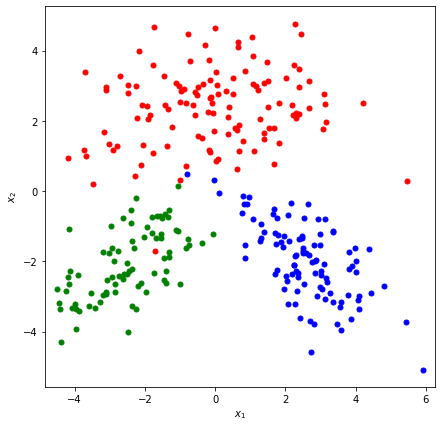

In [4]:
# plot data
plt.figure(figsize = (7, 7))
plt.plot(points1[:, 0], points1[:, 1], "r.", markersize = 10)
plt.plot(points2[:, 0], points2[:, 1], "g.", markersize = 10)
plt.plot(points3[:, 0], points3[:, 1], "b.", markersize = 10)
plt.axis('equal')

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

In [5]:
# write data to a file
np.savetxt("hw03_data_set.csv", np.stack((x[:, 0], x[:, 1], y), axis = 1), fmt = "%f,%f,%d")

In [6]:
# read data into memory
data_set = np.genfromtxt("hw03_data_set.csv", delimiter = ",")

# get x and y values
X = data_set[:,[0, 1]]
y_truth = data_set[:,2].astype(int)

# get number of classes and number of samples
K = np.max(y)
N = data_set.shape[0]

# one-of-K encoding
Y_truth = np.zeros((N, K)).astype(int)
Y_truth[range(N), y_truth - 1] = 1

In [7]:
# learning parameters
eta = 0.01
epsilon = 0.001

In [8]:
# define the sigmoid function
def sigmoid(X, W, w0):
    return(1 / (1 + np.exp(-(np.matmul(X, W) + w0))))

In [9]:
# define the gradient functions
def gradient_W(X, Y_truth, Y_predicted):
    return(np.asarray([-np.matmul(((Y_truth[:,c] - Y_predicted[:,c]) * Y_predicted[:,c] * (1 - Y_predicted[:,c])), X) for c in range(K)]).transpose())

def gradient_w0(Y_truth, Y_predicted):
    return(-np.sum((Y_truth - Y_predicted) * Y_predicted * (1 - Y_predicted), axis = 0))

In [10]:
# randomly initalize W and w0
np.random.seed(521)
W = np.random.uniform(low = -0.01, high = 0.01, size = (X.shape[1], K))
w0 = np.random.uniform(low = -0.01, high = 0.01, size = (1, K))

In [11]:
# learn W and w0 using gradient descent
iteration = 1
objective_values = []
while 1:
    Y_predicted = sigmoid(X, W, w0)

    objective_values = np.append(objective_values, 0.5 * np.sum(np.square(Y_truth - Y_predicted)))

    W_old = W
    w0_old = w0

    W = W - eta * gradient_W(X, Y_truth, Y_predicted)
    w0 = w0 - eta * gradient_w0(Y_truth, Y_predicted)

    if np.sqrt(np.sum((w0 - w0_old))**2 + np.sum((W - W_old)**2)) < epsilon:
        break

    iteration = iteration + 1
print(W)
print(w0)

[[ 0.02528161 -2.23729285  2.44057305]
 [ 4.60790215 -2.46097419 -2.26881565]]
[[-1.13651539 -4.28418412 -3.6081088 ]]


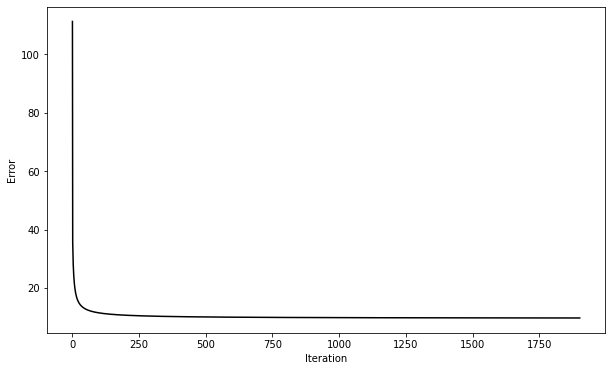

In [12]:
# plot objective function during iterations
plt.figure(figsize = (10, 6))
plt.plot(range(1, iteration + 1), objective_values, "k-")
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.show()

In [13]:
# calculate confusion matrix
y_predicted = np.argmax(Y_predicted, axis = 1) + 1
confusion_matrix = pd.crosstab(y_predicted, y_truth, rownames = ['y_pred'], colnames = ['y_truth'])
print(confusion_matrix)

y_truth    1   2   3
y_pred              
1        117   1   3
2          2  78   0
3          1   1  97


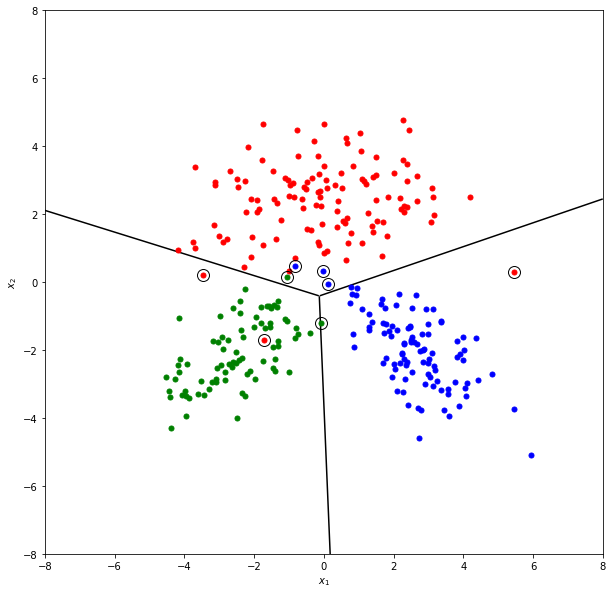

In [14]:
# evaluate discriminant function on a grid
x1_interval = np.linspace(-8, +8, 1201)
x2_interval = np.linspace(-8, +8, 1201)
x1_grid, x2_grid = np.meshgrid(x1_interval, x2_interval)
discriminant_values = np.zeros((len(x1_interval), len(x2_interval), K))
for c in range(K):
    discriminant_values[:,:,c] = W[0, c] * x1_grid + W[1, c] * x2_grid + w0[0, c]

A = discriminant_values[:,:,0]
B = discriminant_values[:,:,1]
C = discriminant_values[:,:,2]
A[(A < B) & (A < C)] = np.nan
B[(B < A) & (B < C)] = np.nan
C[(C < A) & (C < B)] = np.nan
discriminant_values[:,:,0] = A
discriminant_values[:,:,1] = B
discriminant_values[:,:,2] = C

plt.figure(figsize = (10, 10))
plt.plot(X[y_truth == 1, 0], X[y_truth == 1, 1], "r.", markersize = 10)
plt.plot(X[y_truth == 2, 0], X[y_truth == 2, 1], "g.", markersize = 10)
plt.plot(X[y_truth == 3, 0], X[y_truth == 3, 1], "b.", markersize = 10)
plt.plot(X[y_predicted != y_truth, 0], X[y_predicted != y_truth, 1], "ko", markersize = 12, fillstyle = "none")
plt.contour(x1_grid, x2_grid, discriminant_values[:,:,0] - discriminant_values[:,:,1], levels = 0, colors = "k")
plt.contour(x1_grid, x2_grid, discriminant_values[:,:,0] - discriminant_values[:,:,2], levels = 0, colors = "k")
plt.contour(x1_grid, x2_grid, discriminant_values[:,:,1] - discriminant_values[:,:,2], levels = 0, colors = "k")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()